In [21]:
from torch.utils.data import DataLoader
import os

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from _config import PATH_CHECKPOINT, PATH_TO_CONFIG
from data_loader import MyDataLoader
from models import *
from my_config import MyConfig, load_config
from train import model, TARGETS, DEVICE, create_sequences, TimeSeriesDataset, BATCH_SIZE

# Find all checkpoint files in the directory following the pattern checkpoint_{epoch}.pt
checkpoint_files = [f for f in os.listdir(PATH_CHECKPOINT) if f.startswith('checkpoint_') and f.endswith('.pt')]
if checkpoint_files:
    # Sort files by epoch number in descending order and choose the latest checkpoint.
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]), reverse=True)
    latest_checkpoint_file = checkpoint_files[0]

    model.load_state_dict(torch.load(PATH_CHECKPOINT / latest_checkpoint_file, map_location=DEVICE)['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint files found in {PATH_CHECKPOINT}")

# --- Reconstruct continuous one-step-ahead forecasts for 2024

# 1) Reload the full DataFrame (so we get the original timestamps)
my_config: MyConfig = load_config(PATH_TO_CONFIG)
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.lag_features()
data_loader.clean_df()
df_all = data_loader.get_df_from_config()

# 2) Split off features and targets, then isolate year 2024
X_all = df_all.drop(columns=TARGETS)
y_all = df_all[TARGETS]
X_test = X_all.loc['2024-01':'2024-02']
y_test = y_all.loc['2024-01':'2024-02']


print(f'Before creating sequences: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
X_test, y_test, ts = create_sequences(X_test.to_numpy(), y_test.to_numpy(), y_test.index.to_numpy(), 60, rolling=True)
print(f'After creating sequences: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
test_dataset = TimeSeriesDataset(X_test, y_test, device=DEVICE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Before creating sequences: X_test shape: (29670, 3), y_test shape: (29670, 1)
After creating sequences: X_test shape: (25928, 60, 3), y_test shape: (25928, 60, 1)


In [22]:
import numpy as np

model.eval()
preds = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        predictions = model(batch_X)
        preds.append(predictions.cpu().numpy())

In [23]:
y_test = y_test.squeeze()
preds = np.concatenate(preds).squeeze()
display(ts.shape, y_test.shape, preds.shape)

(25928, 60)

(25928, 60)

(25928, 60)

In [24]:
y_test = pd.DataFrame(y_test, index=ts[:, 0])
preds = pd.DataFrame(preds, index=ts[:, 0])
display(y_test.head(),preds.head())

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.009686,0.004017,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998
2024-01-01 07:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.004017,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605
2024-01-01 07:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.012477,...,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777
2024-01-01 07:46:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012477,0.005728,...,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777,0.042302
2024-01-01 07:47:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012477,0.005728,0.013645,...,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777,0.042302,0.031951


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,0.382335,0.107450,0.021617,0.112253,0.226915,0.306063,0.289316,0.235115,0.183414,0.152065,...,0.378236,0.357063,0.333741,0.299175,0.271347,0.259521,0.262194,0.238542,0.139359,0.025690
2024-01-01 07:44:00,0.383405,0.108469,0.020243,0.109990,0.224582,0.303999,0.288044,0.234411,0.182966,0.151444,...,0.355935,0.332330,0.298045,0.269835,0.258242,0.260475,0.237391,0.138948,0.024866,0.110467
2024-01-01 07:45:00,0.381792,0.111261,0.022351,0.108315,0.220592,0.300463,0.285974,0.233131,0.181956,0.150698,...,0.330977,0.296354,0.268281,0.256413,0.258348,0.236078,0.138757,0.023499,0.108728,0.257070
2024-01-01 07:46:00,0.381718,0.114290,0.022312,0.105609,0.217850,0.298525,0.284336,0.231827,0.181234,0.149792,...,0.294694,0.266483,0.254482,0.256014,0.234514,0.138471,0.022258,0.106328,0.254721,0.281660
2024-01-01 07:47:00,0.379696,0.117729,0.023516,0.104163,0.215183,0.295828,0.281786,0.230604,0.180470,0.148835,...,0.265432,0.253281,0.254810,0.233753,0.138475,0.021571,0.104773,0.253109,0.280073,0.276690


In [51]:
df = pd.DataFrame(y_test[0], index=ts[:, 0])
df.columns = ['actual']
df['pred'] = preds[0]
df.head()

,actual,pred
2024-01-01 07:43:00,0.0,0.382335
2024-01-01 07:44:00,0.0,0.383405
2024-01-01 07:45:00,0.0,0.381792
2024-01-01 07:46:00,0.0,0.381718
2024-01-01 07:47:00,0.0,0.379696


<Axes: >

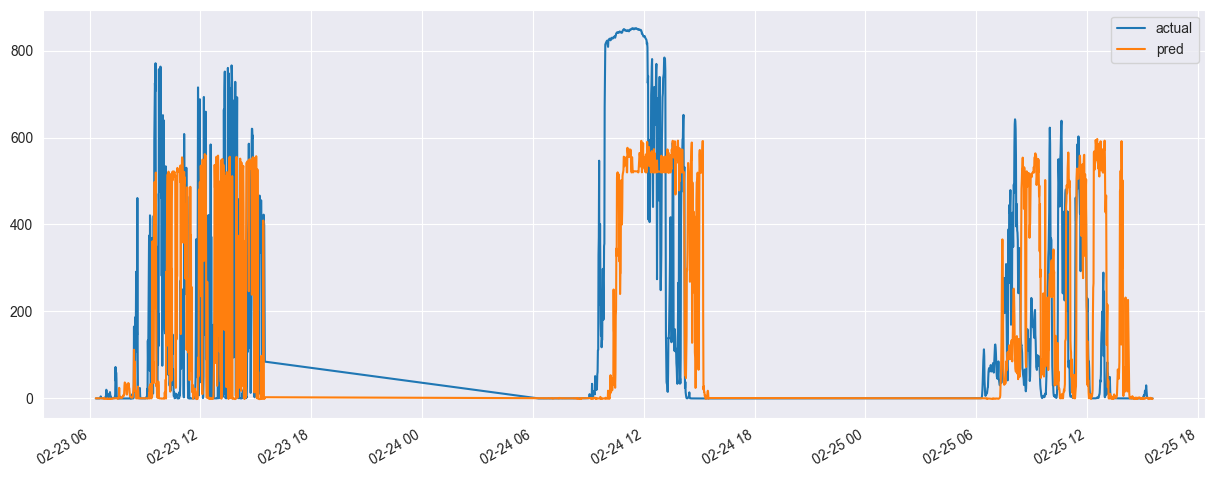

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))
df.loc['2024-02-23':'2024-02-25'].plot(ax=ax)


KeyError: (slice(None, None, None), 0)

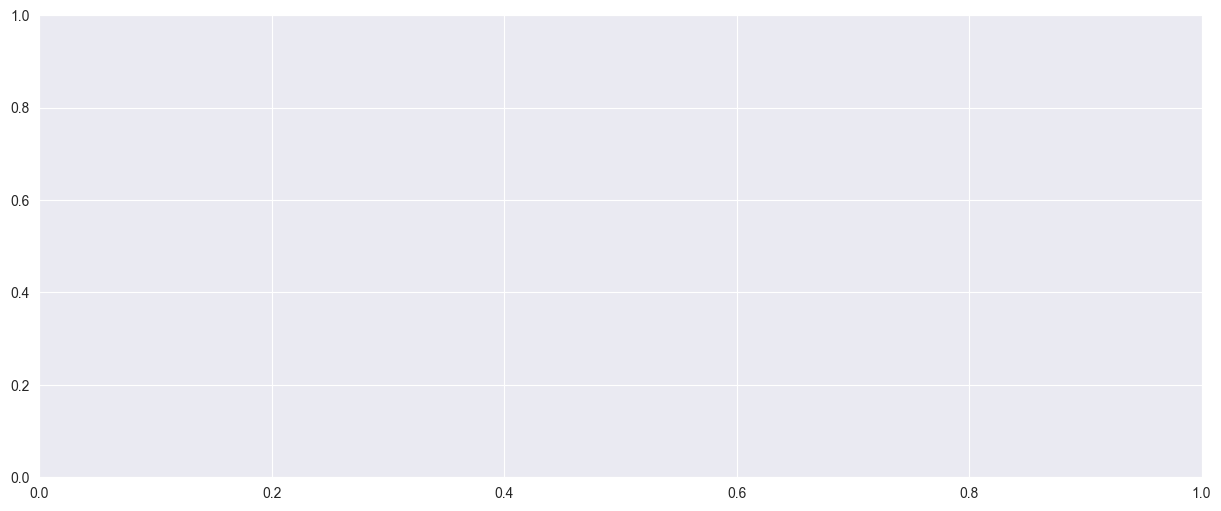

In [52]:
fig, ax = plt.subplots(figsize=(15, 6))
actual = y_test[:, 0]
# plot actual
ax.plot(ts[:, 0], actual, label='True', color='blue')
# plot predicted
for i in range(0, len(preds), 60):
    ax.plot(ts[i:i + 60, 0], preds[i:i + 60, 0], label='Pred', color='red')
ax.set_title(f"True vs Predicted for {TARGETS[0]}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.show()



array(['2024-01-01T07:43:00.000000000', '2024-01-01T07:44:00.000000000',
       '2024-01-01T07:45:00.000000000', ...,
       '2024-02-29T15:39:00.000000000', '2024-02-29T15:40:00.000000000',
       '2024-02-29T15:41:00.000000000'], dtype='datetime64[ns]')

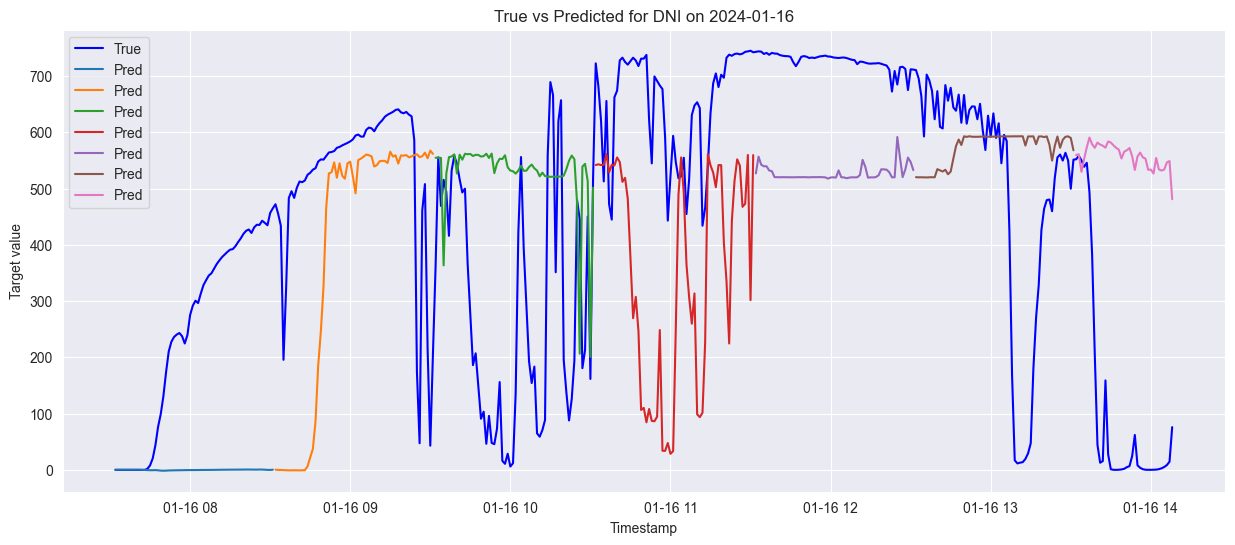

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))
# Select a specific day
day = '2024-01-16'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=1)
# Filter the timestamps for the selected day
day_mask = (ts[:, 0] >= day_start) & (ts[:, 0] < day_end)
# Filter the actual and predicted values for the selected day
day_actual = y_test[day_mask, 0]
day_preds = preds[day_mask, 0]
# Filter the timestamps for the selected day
day_ts = ts[day_mask, 0]
# Plot actual values
ax.plot(day_ts, day_actual, label='True', color='blue')
# Plot predicted values
for i in range(0, len(day_preds), 60):
    ax.plot(day_ts[i:i + 60], day_preds[i:i + 60], label='Pred')
ax.set_title(f"True vs Predicted for {TARGETS[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.legend()
plt.show()




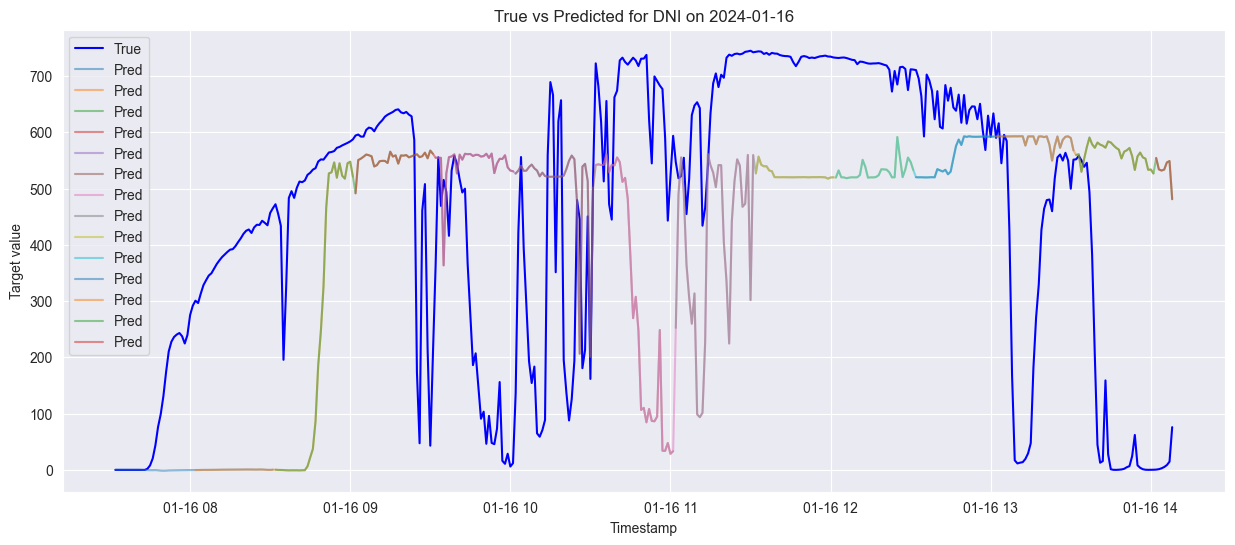

In [52]:
fig, ax = plt.subplots(figsize=(15, 6))
# Select a specific day
day = '2024-01-16'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=1)
# Filter the timestamps for the selected day
day_mask = (ts[:, 0] >= day_start) & (ts[:, 0] < day_end)
# Filter the actual and predicted values for the selected day
day_actual = y_test[day_mask, 0]
day_preds = preds[day_mask, 0]
# Filter the timestamps for the selected day
day_ts = ts[day_mask, 0]
# Plot actual values
ax.plot(day_ts, day_actual, label='True', color='blue')
# Plot predicted values
for i in range(0, len(day_preds), 30):
    ax.plot(day_ts[i:i + 60], day_preds[i:i + 60], label='Pred', alpha=0.5)
ax.set_title(f"True vs Predicted for {TARGETS[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.legend()
plt.show()




In [57]:
preds[day_mask]

array([[3.80694389e-01, 1.71007156e-01, 4.20742035e-02, ...,
        7.61470795e-02, 4.59117889e-02, 6.33907318e-02],
       [3.81842613e-01, 1.71958923e-01, 4.35342789e-02, ...,
        5.00984192e-02, 6.80837631e-02, 8.70962143e-02],
       [3.80954742e-01, 1.68966293e-01, 4.21161652e-02, ...,
        8.30678940e-02, 1.00990295e-01, 6.82964325e-02],
       ...,
       [5.46293579e+02, 3.37173492e+02, 1.80621567e+02, ...,
        1.13673210e+00, 1.21771622e+00, 1.20009041e+00],
       [5.48874634e+02, 3.52356415e+02, 7.40852509e+01, ...,
        1.20619965e+00, 1.18553638e+00, 1.12970257e+00],
       [4.81052124e+02, 1.88400269e+02, 5.27364349e+00, ...,
        1.16456795e+00, 1.11681366e+00, 1.39293003e+00]], dtype=float32)

In [63]:
y_test = pd.DataFrame(y_test, index=ts[:, 0])
y_test

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009686,0.004017,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998
2024-01-01 07:44:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004017,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605
2024-01-01 07:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012477,...,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777
2024-01-01 07:46:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012477,0.005728,...,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777,0.042302
2024-01-01 07:47:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012477,0.005728,0.013645,...,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777,0.042302,0.031951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 15:37:00,135.451825,122.575405,121.477402,131.858363,136.649573,126.667860,113.891264,100.715400,84.135780,70.830160,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 15:38:00,122.575405,121.477402,131.858363,136.649573,126.667860,113.891264,100.715400,84.135780,70.830160,65.709539,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 15:39:00,121.477402,131.858363,136.649573,126.667860,113.891264,100.715400,84.135780,70.830160,65.709539,63.753119,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-02-29 15:40:00,131.858363,136.649573,126.667860,113.891264,100.715400,84.135780,70.830160,65.709539,63.753119,58.632501,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


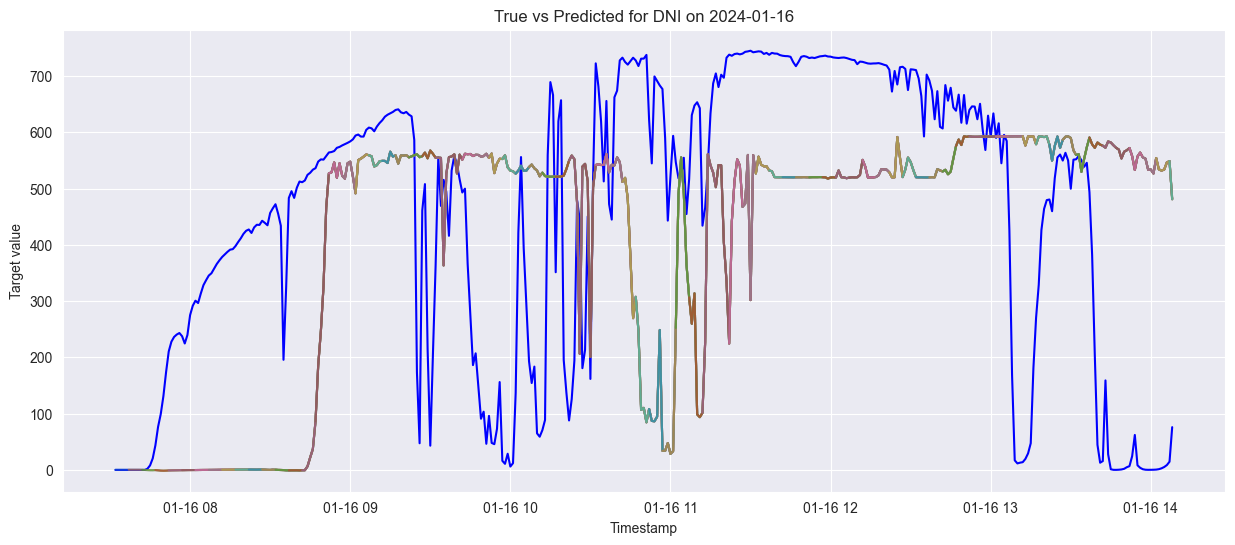

In [55]:
fig, ax = plt.subplots(figsize=(15, 6))
# Select a specific day
day = '2024-01-16'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=1)
# Filter the timestamps for the selected day
day_mask = (ts[:, 0] >= day_start) & (ts[:, 0] < day_end)
# Filter the actual and predicted values for the selected day
day_actual = y_test[day_mask, 0]
day_preds = preds[day_mask, 0]
# Filter the timestamps for the selected day
day_ts = ts[day_mask, 0]
# Plot actual values
ax.plot(day_ts, day_actual, label='True', color='blue')
# Plot predicted values
for i in range(0, len(day_preds), 5):
    ax.plot(day_ts[i:i + 60], day_preds[i:i + 60], label='Pred', alpha=0.5)
ax.set_title(f"True vs Predicted for {TARGETS[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
plt.show()




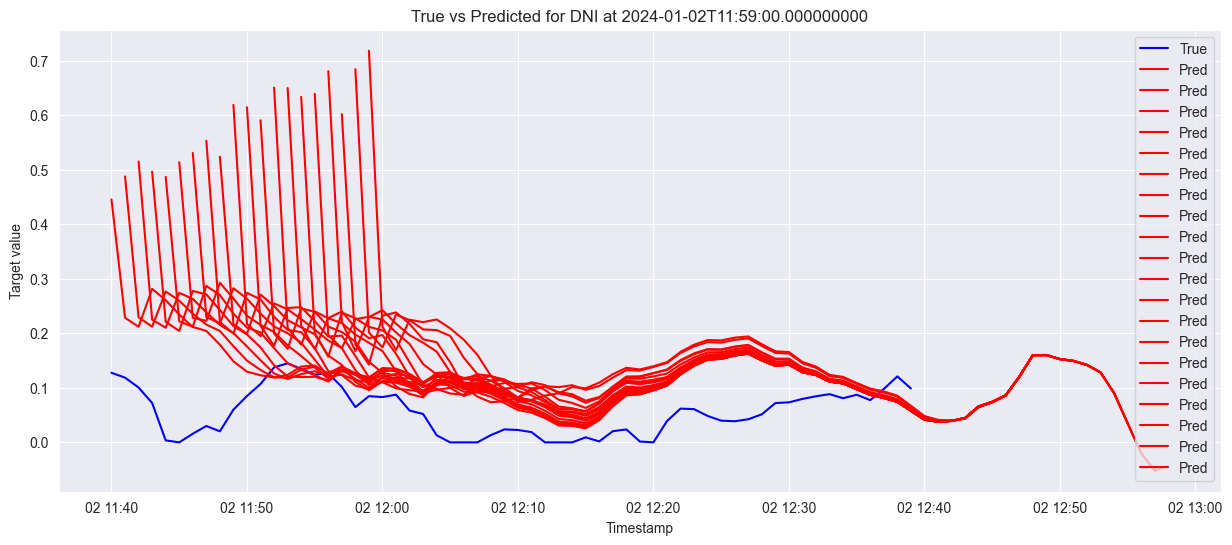

In [30]:
fig, ax = plt.subplots(figsize=(15, 6))
i = 2* 60*5
ax.plot(ts[i], y_test[i], label='True', color='blue')
for i in range(i, i+ 20):
    ax.plot(ts[i], preds[i], label='Pred', color='red')

ax.set_title(f"True vs Predicted for {TARGETS[0]} at {ts[i][0]}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Target value")
ax.legend()
plt.show()

In [91]:
df = pd.DataFrame(preds, index=y_test_df[seq_len:].index)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 08:43:00,0.382334,0.107447,0.021616,0.112251,0.226918,0.306062,0.289315,0.235115,0.183416,0.152065,...,0.378235,0.357064,0.333741,0.299177,0.271349,0.259521,0.262193,0.238542,0.139360,0.025688
2024-01-01 08:44:00,0.383400,0.108465,0.020249,0.109987,0.224584,0.303997,0.288046,0.234409,0.182968,0.151447,...,0.355935,0.332330,0.298045,0.269835,0.258245,0.260477,0.237391,0.138947,0.024868,0.110469
2024-01-01 08:45:00,0.381792,0.111262,0.022353,0.108316,0.220590,0.300463,0.285973,0.233130,0.181958,0.150702,...,0.330980,0.296352,0.268280,0.256413,0.258352,0.236080,0.138757,0.023500,0.108729,0.257067
2024-01-01 08:46:00,0.381718,0.114294,0.022311,0.105607,0.217847,0.298531,0.284331,0.231830,0.181233,0.149790,...,0.294689,0.266487,0.254484,0.256016,0.234512,0.138472,0.022257,0.106331,0.254721,0.281658
2024-01-01 08:47:00,0.379698,0.117729,0.023516,0.104162,0.215185,0.295828,0.281789,0.230602,0.180470,0.148834,...,0.265430,0.253280,0.254812,0.233754,0.138475,0.021574,0.104773,0.253107,0.280069,0.276690


In [104]:
row = df.loc['2024-01-16'].iloc[0]
sub_df = pd.DataFrame(row.values, pd.date_range(start=row.name,  periods=seq_len, freq='1min'), columns=["prediction"])
sub_df


,prediction
2024-01-16 07:32:00,522.386597
2024-01-16 07:33:00,648.150208
2024-01-16 07:34:00,629.954468
2024-01-16 07:35:00,609.238708
2024-01-16 07:36:00,604.562988
2024-01-16 07:37:00,599.244934
2024-01-16 07:38:00,592.956909
2024-01-16 07:39:00,526.926147
2024-01-16 07:40:00,524.382629
2024-01-16 07:41:00,551.291016


<Axes: >

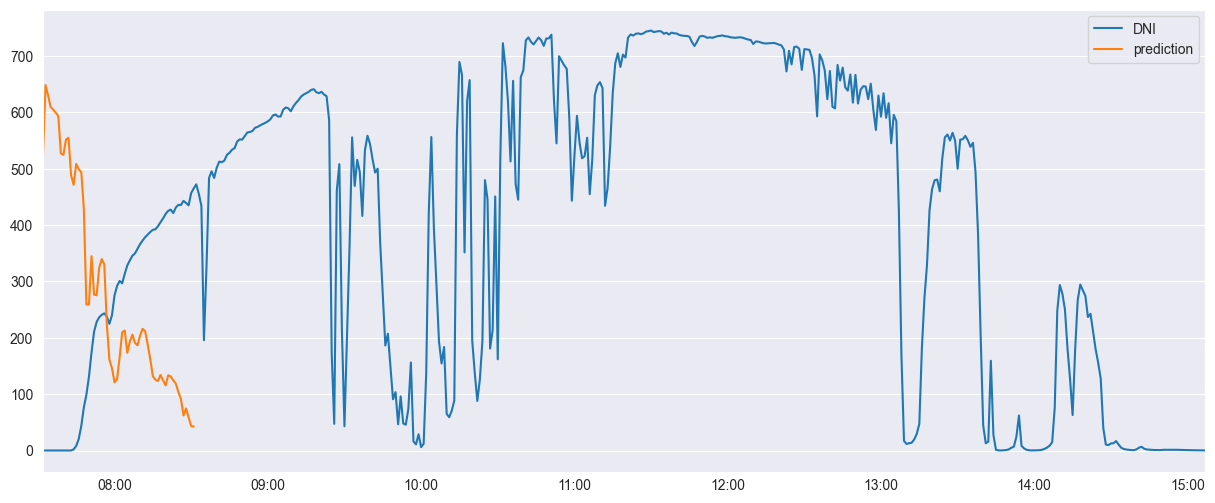

In [106]:
fig, ax = plt.subplots(figsize=(15, 6))
y_test_df[seq_len:].loc['2024-01-16'].plot(ax=ax)
sub_df.plot(ax=ax)

In [25]:
z = list(zip(y_test_df[seq_len:].index, preds))

In [42]:
for ts, pred in z[0:1]:
    datetime_range = pd.date_range(start=ts,  periods=seq_len, freq='1min')
    print(f"Timestamp: {datetime_range}")

Timestamp: DatetimeIndex(['2024-01-01 08:43:00', '2024-01-01 08:44:00',
               '2024-01-01 08:45:00', '2024-01-01 08:46:00',
               '2024-01-01 08:47:00', '2024-01-01 08:48:00',
               '2024-01-01 08:49:00', '2024-01-01 08:50:00',
               '2024-01-01 08:51:00', '2024-01-01 08:52:00',
               '2024-01-01 08:53:00', '2024-01-01 08:54:00',
               '2024-01-01 08:55:00', '2024-01-01 08:56:00',
               '2024-01-01 08:57:00', '2024-01-01 08:58:00',
               '2024-01-01 08:59:00', '2024-01-01 09:00:00',
               '2024-01-01 09:01:00', '2024-01-01 09:02:00',
               '2024-01-01 09:03:00', '2024-01-01 09:04:00',
               '2024-01-01 09:05:00', '2024-01-01 09:06:00',
               '2024-01-01 09:07:00', '2024-01-01 09:08:00',
               '2024-01-01 09:09:00', '2024-01-01 09:10:00',
               '2024-01-01 09:11:00', '2024-01-01 09:12:00',
               '2024-01-01 09:13:00', '2024-01-01 09:14:00',
             

In [ ]:



# 5) Build DataFrames aligned on time
pred_df = pd.DataFrame(preds, index=timestamps, columns=TARGETS)
true_df = y_test_df.iloc[seq_len:]

In [ ]:
# 6) Plot full-year one-step-ahead vs true
plt.figure(figsize=(15, 6))
for target in TARGETS:
    plt.plot(true_df.index, true_df[target], label=f"True {target}")
    plt.plot(pred_df.index, pred_df[target], '--', label=f"Pred {target}")
plt.title("One-Step-Ahead Predictions vs. True Values for 2024")
plt.xlabel("Timestamp")
plt.ylabel("Target value")
plt.legend()
plt.tight_layout()
plt.show()